# First model: a single hidden layer

In [1]:
%matplotlib inline

import os
import time
import numpy as np
import matplotlib
from matplotlib import pyplot
from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [5]:
from nolearn.lasagne import BatchIterator

ValueError: You are tring to use the old GPU back-end. It was removed from Theano. Use device=cuda* now. See https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29 for more information.

In [2]:
from nolearn.lasagne import BatchIterator

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.7 or higher required)
NoneType: None


ImportError: cannot import name 'downsample'

In [4]:
import pygpu
pygpu.version.fullversion

ModuleNotFoundError: No module named 'pygpu'

In [2]:
import pygpu

ImportError: libgpuarray.so.3: cannot open shared object file: No such file or directory

In [2]:
import pygpu

In [4]:
pygpu.__version__

'0.7.5+9.gdfadef3'

In [5]:
from nolearn.lasagne import BatchIterator

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Using cuDNN version 7005 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)


ImportError: cannot import name 'downsample'

In [7]:
import theano
theano.__version__

'1.0.1'

In [8]:
import lasagne

ImportError: cannot import name 'downsample'

In [2]:
import lasagne
lasagne.__version__

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Using cuDNN version 7005 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)


'0.2.dev1'

Finally, everything works!

In [3]:
from nolearn.lasagne import BatchIterator

/home/ubuntu/anaconda2/envs/tf/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
import tensorflow as tf
tf.__version__

'1.5.0'

## Loading data

To download data files from this competition, use the [unofficial Kaggle CLI tool](https://github.com/floydwch/kaggle-cli). Install this tool first before running the next command.

In [5]:
!kg --version

kg 0.12.13


In [8]:
!kg --help

usage: kg [--version] [-v | -q] [--log-file LOG_FILE] [-h] [--debug]

An unofficial Kaggle command line tool.

optional arguments:
  --version            show program's version number and exit
  -v, --verbose        Increase verbosity of output. Can be repeated.
  -q, --quiet          Suppress output except warnings and errors.
  --log-file LOG_FILE  Specify a file to log output. Disabled by default.
  -h, --help           Show help message and exit.
  --debug              Show tracebacks on errors.

Commands:
  complete       print bash completion command
  config         Set config.
  dataset        Download dataset from a specific user.
  download       Download data files from a specific competition.
  help           print detailed help for another command
  submissions    List recent submissions.
  submit         Submit an entry to a specific competition.


In [ ]:
%mkdir data
%cd data

In [ ]:
!kg download -u '<username>' -p '<password>' -c 'facial-keypoints-detection'

In [11]:
!unzip training.zip & unzip test.zip

Archive:  training.zip
Archive:  test.zip
  inflating: test.csv                  inflating: training.csv            


In [12]:
!ls -la

total 194112
drwxrwxr-x 2 ubuntu ubuntu     4096 Jan 31 18:49 .
drwxrwxr-x 4 ubuntu ubuntu     4096 Jan 31 18:49 ..
-rw-rw-r-- 1 ubuntu ubuntu   862732 Jan 31 18:48 IdLookupTable.csv
-rw-rw-r-- 1 ubuntu ubuntu   205901 Jan 31 18:48 SampleSubmission.csv
-rw-r--r-- 1 ubuntu ubuntu 59822141 Apr 27  2013 test.csv
-rw-rw-r-- 1 ubuntu ubuntu 16765834 Jan 31 18:48 test.zip
-rw-rw-r-- 1 ubuntu ubuntu 58064896 Jan 31 18:49 training.csv
-rw-rw-r-- 1 ubuntu ubuntu 63023793 Jan 31 18:48 training.zip


In [13]:
!rm training.zip test.zip

In [15]:
%cd ..

/home/ubuntu/development/gh-repo/kaggle-facial-detection/notebooks


Paths to datasets.

In [70]:
FROOT = os.getcwd() # Path to your project folder
FTRAIN = FROOT + '/data/training.csv'
FTEST = FROOT + '/data/test.csv'
FLOOKUP = FROOT + '/data/IdLookupTable.csv'

In [71]:
def load(test=False, cols=None):
    """
    Loads the dataset.

    Parameters
    ----------
    test  : optional, defaults to `False`
            Flag indicating if we need to load from `FTEST` (`True`) or `FTRAIN` (`False`)
    cols  : optional, defaults to `None`
            A list of columns you're interested in. If specified only returns these columns.

    Returns
    -------
    A tuple of X and y, if `test` was set to `True` y contains `None`.
    """

    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

In [21]:
def plot_sample(x, y, axis):
    """
    Plots a single sample image with keypoints on top.

    Parameters
    ----------
    x     : Image data.
    y     : Keypoints to plot.
    axis  : Plot over which to draw the sample.
    """
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

Load the training dataset.

In [74]:
X, y = load()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

Verify that data is ok by querying and plotting an arbitrary image.

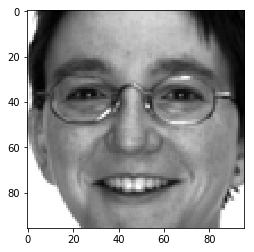

In [89]:
img = X[11].reshape(96, 96)
pyplot.imshow(img, cmap='gray')
pyplot.show()

In [91]:
y[11].shape # 30 labels (30 keypoints)

(30,)

Split the initial training dataset into training, validation and testing datasets.

In [92]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

## Parameters

In [93]:
# Predefined parameters
image_size = 96
num_keypoints = 30
batch_size = 36
num_epochs = 1001
learning_rate = 0.01
momentum = 0.9

model_name = "1fc_b" + str(batch_size) + "_e" + str(num_epochs - 1)
model_variable_scope = model_name
root_location = FROOT + "/models/"
model_path = root_location + model_name + "/model.ckpt"
train_history_path = root_location + model_name + "/train_history"

os.makedirs(root_location + model_name + "/", exist_ok = True)

## Routines

Performs a single fully connected layer pass, e.g. returns input * weights + bias:

In [97]:
def fully_connected(input, size):
    """
    Creates a fully connected TensorFlow layer.

    Parameters
    ----------
    input  : Input tensor for calculating layer shape.
    size   : Layer size, e.g. number of units.

    Returns
    -------
    A graph variable calculating single fully connected layer.
    """
    weights = tf.get_variable( 'weights',
        shape = [input.get_shape()[1], size],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    biases = tf.get_variable( 'biases',
        shape = [size],
        initializer=tf.constant_initializer(0.0)
      )
    return tf.matmul(input, weights) + biases

Performs entire model pass, e.g. returns model prediction for given input with current model (single hidden fully connected layer):

In [98]:
def model_pass(input):
    """
    Performs a whole model pass.

    Parameters
    ----------
    input : Input tensor to be passed through the model.
    Returns
    -------
    Model prediction.
    """
    with tf.variable_scope('hidden'):
        hidden = fully_connected(input, size = 100)
    relu_hidden = tf.nn.relu(hidden)
    with tf.variable_scope('out'):
        prediction = fully_connected(relu_hidden, size = num_keypoints)
    return prediction

Calculates loss based on model predictions.

In [99]:
def calc_loss(predictions, labels):
    """
    Calculates loss with NumPy.

    Parameters
    ----------
    predictions : ndarray 
                  Predictions.
    labels      : ndarray
                  Actual values.

    Returns
    -------
    Squared mean error for given predictions.
    """
    return np.mean(np.square(predictions - labels))

Calculates time since start and formats as a string.

In [100]:
def get_time_hhmmss(start):
    """
    Calculates time since `start` and formats as a string.

    Parameters
    ----------
    start : Time starting point.

    Returns
    -------
    Nicely formatted time difference between now and `start`.
    """
    end = time.time()
    m, s = divmod(end - start, 60)
    h, m = divmod(m, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    return time_str

## Training

In [101]:
graph = tf.Graph()

with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    tf_x_batch = tf.placeholder(tf.float32, shape = (None, image_size * image_size))
    tf_y_batch = tf.placeholder(tf.float32, shape = (None, num_keypoints))

    # Training computation.
    with tf.variable_scope(model_variable_scope):
        predictions = model_pass(tf_x_batch)

    loss = tf.reduce_mean(tf.square(predictions - tf_y_batch))

    # Optimizer.
    optimizer = tf.train.MomentumOptimizer(
        learning_rate = learning_rate,
        momentum = momentum,
        use_nesterov = True
    ).minimize(loss)

In [102]:
def get_predictions_in_batches(X, session):
    """
    Calculates predictions in batches of 128 examples at a time, using `session`'s calculation graph.

    Parameters
    ----------
    X       : ndarray
              Dataset to get predictions for.
    session : TensorFlow session to be used for predicting. Is expected to have a `predictions` var 
              in the graph along with a `tf_x_batch` placeholder for incoming data.

    Returns
    -------
    N-dimensional array of predictions.
    """
    p = []
    batch_iterator = BatchIterator(batch_size = 128)
    for x_batch, _ in batch_iterator(X):
        [p_batch] = session.run([predictions], feed_dict = {
                tf_x_batch : x_batch
            }
        )
        p.extend(p_batch)
    return p

In [103]:
start = time.time()
every_epoch_to_log = 5

with tf.Session(graph = graph) as session:
    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    train_loss_history = np.zeros(num_epochs)
    valid_loss_history = np.zeros(num_epochs)
    
    print("============ TRAINING =============")
    for epoch in range(num_epochs):
        # Train on whole randomised dataset in batches
        batch_iterator = BatchIterator(batch_size = batch_size, shuffle = True)
        for x_batch, y_batch in batch_iterator(x_train, y_train):
            session.run([optimizer], feed_dict = {
                    tf_x_batch : x_batch,
                    tf_y_batch : y_batch
                }
            )

        # If another significant epoch ended, we log our losses.
        if (epoch % every_epoch_to_log == 0):
            # Get training data predictions and log training loss:
            train_loss = calc_loss(
                get_predictions_in_batches(x_train, session),
                y_train
            )
            train_loss_history[epoch] = train_loss

            # Get validation data predictions and log validation loss:
            valid_loss = calc_loss(
                get_predictions_in_batches(x_valid, session),
                y_valid
            )
            valid_loss_history[epoch] = valid_loss

            if (epoch % 100 == 0):
                print("--------- EPOCH %4d/%d ---------" % (epoch, num_epochs))
                print("     Train loss: %.8f" % (train_loss))
                print("Validation loss: %.8f" % (valid_loss))
                print("           Time: " + get_time_hhmmss(start))

    # Evaluate on test dataset.
    test_loss = calc_loss(
        get_predictions_in_batches(x_test, session),
        y_test
    )
    print("===================================")
    print(" Test score: %.3f (loss = %.8f)" % (np.sqrt(test_loss) * 48.0, test_loss))
    print(" Total time: " + get_time_hhmmss(start))

    # Save model weights for future use.
    save_path = saver.save(session, model_path)
    print("Model file: " + save_path)
    np.savez(train_history_path, train_loss_history = train_loss_history, valid_loss_history = valid_loss_history)
    print("Train history file: " + train_history_path)

============ TRAINING =============
--------- EPOCH    0/1001 ---------
     Train loss: 0.01320032
Validation loss: 0.01446179
           Time: 00:00:00
--------- EPOCH  100/1001 ---------
     Train loss: 0.00296538
Validation loss: 0.00475665
           Time: 00:00:11
--------- EPOCH  200/1001 ---------
     Train loss: 0.00198980
Validation loss: 0.00372262
           Time: 00:00:22
--------- EPOCH  300/1001 ---------
     Train loss: 0.00165424
Validation loss: 0.00346788
           Time: 00:00:33
--------- EPOCH  400/1001 ---------
     Train loss: 0.00147648
Validation loss: 0.00340713
           Time: 00:00:44
--------- EPOCH  500/1001 ---------
     Train loss: 0.00131182
Validation loss: 0.00328698
           Time: 00:00:55
--------- EPOCH  600/1001 ---------
     Train loss: 0.00117482
Validation loss: 0.00323468
           Time: 00:01:06
--------- EPOCH  700/1001 ---------
     Train loss: 0.00111791
Validation loss: 0.00325826
           Time: 00:01:17
--------- EPOCH  800

## Evaluation

In [104]:
# Plots history of learning curves for a specific model. You may want to call `pyplot.show()` afterwards.
def plot_learning_curves(model = model_name, linewidth = 2, train_linestyle = "b-", valid_linestyle = "g-"):
    """
    Plots history of learning curves for a specific model based on the saved training history.
    You may want to call `pyplot.show()` afterwards.

    Parameters
    ----------
    model             : optional, defaults to current model name
                        Model name.
    linewidth         : optional, defaults to 2
                        Line thickness.
    train_linestyle   : optional, defaults to "b-"
                        Matplotlib line style for the training curve.
    valid_linestyle   : optional, defaults to "g-"
                        Matplotlib line style for the validation curve.

    Returns
    -------
    Number of epochs plotted.
    """
    model_history = np.load(root_location + model + "/train_history.npz")
    train_loss = model_history["train_loss_history"]
    valid_loss = model_history["valid_loss_history"]
    epochs = train_loss.shape[0]
    x_axis = np.arange(epochs)
    pyplot.plot(x_axis[train_loss > 0], train_loss[train_loss > 0], train_linestyle, linewidth=linewidth, label=model + " train")
    pyplot.plot(x_axis[valid_loss > 0], valid_loss[valid_loss > 0], valid_linestyle, linewidth=linewidth, label=model + " valid")
    return epochs

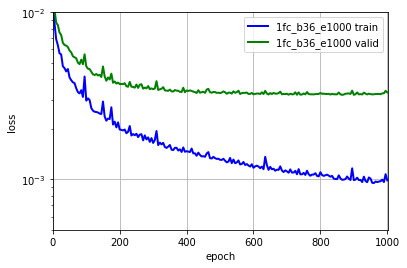

In [105]:
new_model_epochs = plot_learning_curves()

pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(0.0005, 0.01)
pyplot.xlim(0, new_model_epochs)
pyplot.yscale("log")
pyplot.show()

Now, let's take a look at the data and predictions.

Load training data, restore saved model parameters and get predictions:

In [106]:
X, _ = load(test=True)

with graph.as_default():
    tf_x = tf.constant(X)

    with tf.variable_scope(model_variable_scope, reuse=True):
        tf_p = model_pass(tf_x)

with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    load_path = saver.restore(session, model_path)
    p = tf_p.eval()

ImageId    1783
Image      1783
dtype: int64
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /home/ubuntu/development/gh-repo/kaggle-facial-detection/notebooks/models/1fc_b36_e1000/model.ckpt


Display some of the dataset images and our model's predictions:

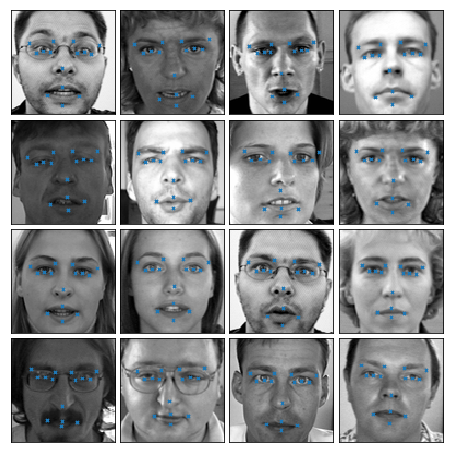

In [107]:
fig = pyplot.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], p[i], ax)

pyplot.show()

Our first model's predictions on 16 samples taken from the test set.

The predictions look reasonable, but sometimes they are quite a bit off. Let's try and do a bit better.